Can't run the following cell:

In [ ]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from core import *
from torch_backend import *

### Network definitions

In [2]:
def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    block['add'] =  (Add(), [(rel_path('conv3') if projection else rel_path('relu1')), rel_path('branch', 'conv2')])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), [rel_path('in')]),
        'concat': (Concat(), [rel_path('maxpool'), rel_path('avgpool')]),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'classifier': Identity(),
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'classifier': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n


losses = {
    'loss':  (nn.CrossEntropyLoss(reduce=False), [('classifier',), ('target',)]),
    'correct': (Correct(), [('classifier',), ('target',)]),
}

remove_identity_nodes = lambda net: remove_by_type(net, Identity)

/disk/scratch/gavin/conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### Download and preprocess data

In [3]:
DATA_DIR = '../../data'
dataset = cifar10(DATA_DIR)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(dataset['test']['data'])), dataset['test']['labels']))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 3.4 seconds
Preprocessing test data
Finished in 0.17 seconds


### Training loop

In [4]:
def train(model, lr_schedule, optimizer, train_set, test_set, batch_size, num_workers=0):
    train_batches = Batches(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=num_workers)
    optimizer.opt_params['lr'] = lambda step: lr_schedule(step/len(train_batches))/batch_size
    table, timer = TableLogger(), Timer()
    for epoch in range(lr_schedule.knots[-1]):
        epoch_stats = train_epoch(model, train_batches, test_batches, optimizer.step, timer, test_time_in_total=True) 
        summary = union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)}, epoch_stats)
        table.append(summary)
    return summary

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - DAWNbench baseline + no initial bn-relu+ efficient dataloading/augmentation, 1 dataloader process (301s)

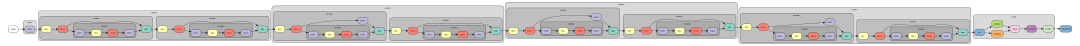

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067      20.7577       1.6877       0.3750       1.7178       1.2603       0.5321      22.4754
           2       0.0133      19.5207       1.0062       0.6366       1.2307       0.9342       0.6665      43.2269
           3       0.0200      19.4554       0.7514       0.7393       1.2429       0.7887       0.7314      63.9252
           4       0.0267      19.4599       0.6316       0.7804       1.2194       0.7227       0.7565      84.6045
           5       0.0333      19.4486       0.5698       0.8025       1.2139       0.5638       0.8068     105.2670
           6       0.0400      19.4022       0.5067       0.8257       1.2359       0.5445       0.8192     125.9052
           7       0.0467      19.4571       0.4730       0.8362       1.2830       0.5428       0.8156     146.6452
           8       0.0533      19.4998       0.4414       0.8471

In [5]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=1)

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - 0 dataloader processes (297s)

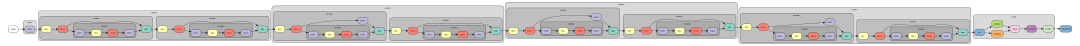

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067      19.2136       1.6845       0.3732       1.0343       1.3005       0.5293      20.2480
           2       0.0133      19.2254       1.0419       0.6260       1.0182       0.9175       0.6834      40.4916
           3       0.0200      19.2075       0.7721       0.7287       1.0223       1.0633       0.6673      60.7215
           4       0.0267      19.2319       0.6485       0.7732       1.0190       0.7203       0.7549      80.9723
           5       0.0333      19.2187       0.5669       0.8040       1.0211       0.6352       0.7828     101.2121
           6       0.0400      19.2534       0.5101       0.8245       1.0237       0.6148       0.7896     121.4891
           7       0.0467      19.2824       0.4695       0.8378       1.0379       0.5985       0.8002     141.8094
           8       0.0533      19.2521       0.4407       0.8488

In [6]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size,  num_workers=0)

### [Post 2: Mini-batches](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_2/) - batch size=512 (256s)

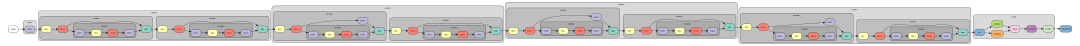

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293      20.1612       1.7246       0.3561       1.3406       1.5417       0.4616      21.5019
           2       0.0587      16.3261       1.0995       0.6069       0.9656       1.0381       0.6455      38.7936
           3       0.0880      16.3526       0.7900       0.7202       0.9609       1.0852       0.6676      56.1070
           4       0.1173      16.3534       0.6455       0.7754       0.9674       0.6838       0.7723      73.4278
           5       0.1467      16.3441       0.5622       0.8054       0.9684       0.6415       0.7933      90.7403
           6       0.1760      16.3554       0.4998       0.8270       0.9629       0.5433       0.8140     108.0586
           7       0.2053      16.3447       0.4586       0.8418       0.9672       0.5297       0.8223     125.3705
           8       0.2347      16.3540       0.4224       0.8536

In [7]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - speed up batch norms (186s)

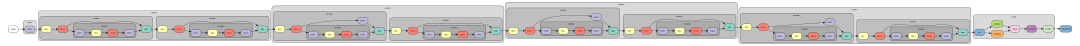

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293      15.4455       1.7220       0.3586       0.9569       1.4600       0.4802      16.4024
           2       0.0587      15.4639       1.0878       0.6074       0.9630       1.0938       0.6370      32.8294
           3       0.0880      15.4772       0.7677       0.7299       0.9620       0.9767       0.7064      49.2686
           4       0.1173      15.4791       0.6186       0.7837       0.9694       0.8007       0.7250      65.7170
           5       0.1467      15.4864       0.5414       0.8119       0.9646       0.6010       0.7974      82.1681
           6       0.1760      15.4637       0.4881       0.8317       0.9637       0.6686       0.7823      98.5955
           7       0.2053      15.4803       0.4471       0.8453       0.9598       0.7080       0.7706     115.0356
           8       0.2347      15.4726       0.4136       0.8558

In [8]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - cutout+30 epochs+batch_size=512 (161s)

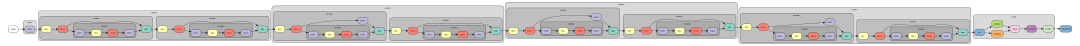

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0500      15.4487       1.7143       0.3620       0.9563       1.6435       0.4592      16.4049
           2       0.1000      15.4595       1.1383       0.5946       0.9611       1.6156       0.5231      32.8255
           3       0.1500      15.4732       0.8610       0.6953       0.9641       0.9093       0.6933      49.2628
           4       0.2000      15.4585       0.7232       0.7480       0.9659       0.8492       0.7183      65.6872
           5       0.2500      15.4638       0.6337       0.7796       0.9691       0.6376       0.7828      82.1201
           6       0.3000      15.4704       0.5715       0.8017       0.9665       0.7770       0.7392      98.5569
           7       0.3500      15.4805       0.5375       0.8157       0.9606       0.6554       0.7730     114.9980
           8       0.4000      15.4668       0.5293       0.8160

In [9]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.4, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/)  - batch_size=768 (154s)

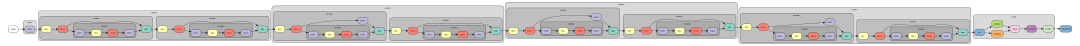

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0750      18.0195       1.7629       0.3434       0.8977       2.1863       0.3247      18.9171
           2       0.1500      15.2420       1.2366       0.5504       0.9093       1.8863       0.4614      35.0685
           3       0.2250      15.2370       0.9449       0.6629       0.8945       1.5924       0.5534      51.2000
           4       0.3000      15.2262       0.7598       0.7328       0.8942       0.8462       0.7140      67.3204
           5       0.3750      15.2473       0.6451       0.7753       0.8976       0.8841       0.6939      83.4654
           6       0.4500      15.2503       0.6019       0.7904       0.8997       1.1872       0.6084      99.6154
           7       0.5250      15.2332       0.5513       0.8077       0.8986       0.7739       0.7432     115.7472
           8       0.6000      15.2326       0.5404       0.8135

In [10]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.6, 0])
batch_size = 768

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone (36s; test acc 55.9%)

It seems reasonable to study how the shortest path through the network trains in isolation and to take steps to improve this before adding back the longer branches. 
Eliminating the long branches yields the following backbone network in which all convolutions, except for the initial one, have a stride of two.

Training the shortest path network for 20 epochs yields an unimpressive test accuracy of 55.9% in 36 seconds.

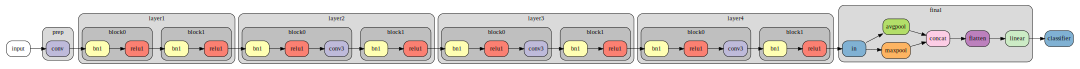

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.9916       1.9762       0.2676       0.1886       1.7576       0.3555       3.1802
           2       0.2000       2.7659       1.7604       0.3551       0.2150       1.6596       0.4004       6.1611
           3       0.3000       2.8165       1.6995       0.3821       0.1821       1.6602       0.3999       9.1596
           4       0.4000       3.0525       1.6684       0.3957       0.2471       1.6245       0.4148      12.4592
           5       0.3750       3.0750       1.6503       0.4033       0.1889       1.5681       0.4343      15.7231
           6       0.3500       2.9100       1.6196       0.4155       0.1928       1.6488       0.4058      18.8259
           7       0.3250       2.9192       1.5922       0.4236       0.1949       1.5646       0.4281      21.9400
           8       0.3000       2.6038       1.5687       0.4321

In [11]:
def shortcut_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    return block

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block)
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, remove repeat bn-relu (32s; test acc 56.0%)

Removing the repeated batch norm-ReLU groups, reduces training time to 32s and leaves test accuracy approximately unchanged.

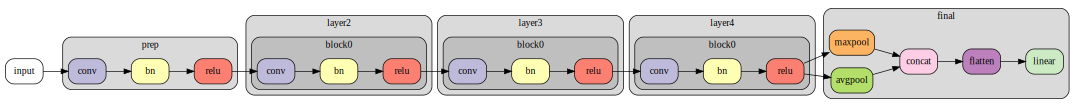

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.4416       1.9587       0.2819       0.1868       1.7720       0.3585       2.6284
           2       0.2000       2.4747       1.7407       0.3631       0.1522       1.7056       0.3952       5.2553
           3       0.3000       2.5481       1.6717       0.3908       0.2352       1.6029       0.4271       8.0386
           4       0.4000       2.4451       1.6503       0.4032       0.1953       1.6589       0.4036      10.6790
           5       0.3750       2.6530       1.6436       0.4097       0.2277       1.5619       0.4355      13.5597
           6       0.3500       2.6663       1.6024       0.4216       0.1912       1.5366       0.4539      16.4172
           7       0.3250       2.7819       1.5840       0.4265       0.1932       1.5445       0.4519      19.3922
           8       0.3000       2.8645       1.5505       0.4391

In [12]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv':  nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 3x3 convs (36s; test acc 85.6%)

A serious shortcoming of this network is that the downsampling convolutions have 1x1 kernels and a stride of two, so that rather than enlarging the receptive field they are simply discarding information. 

If we replace these with 3x3 convolutions, things improve considerably and test accuracy after 20 epochs is 85.6% in a time of 36s.

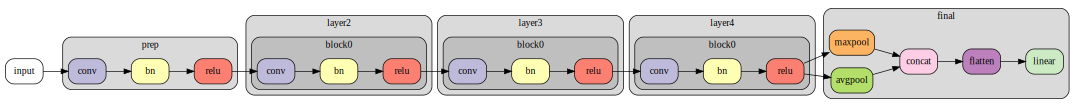

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       3.7516       1.7267       0.3699       0.2078       1.5896       0.4470       3.9594
           2       0.2000       3.6659       1.3176       0.5253       0.2189       1.1613       0.5835       7.8442
           3       0.3000       3.6786       1.1268       0.5941       0.2082       1.1895       0.5808      11.7310
           4       0.4000       3.7666       1.0752       0.6162       0.2392       0.9316       0.6727      15.7367
           5       0.3750       3.6693       0.9912       0.6510       0.2548       1.0667       0.6269      19.6609
           6       0.3500       3.6546       0.9017       0.6813       0.2081       0.7910       0.7272      23.5236
           7       0.3250       3.7235       0.8447       0.7043       0.2145       0.7997       0.7202      27.4617
           8       0.3000       3.7043       0.8034       0.7181

In [13]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, maxpool downsampling (43s; test acc 89.7%)

We can further improve the downsampling stages by applying 3x3 convolutions of stride one followed by a pooling layer instead of using strided convolutions. 

We choose max pooling with a 2x2 window size leading to a final test accuracy of 89.7% after 43s. Using average pooling gives a similar result but takes slightly longer.

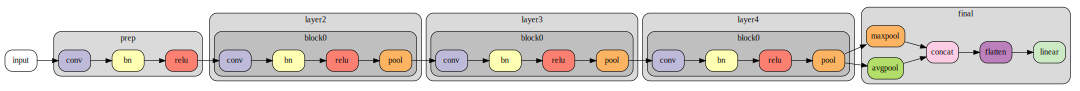

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       7.5611       1.6879       0.3909       0.5158       1.3167       0.5323       8.0769
           2       0.2000       5.8545       1.1527       0.5914       0.3772       0.9419       0.6672      14.3086
           3       0.3000       5.8244       0.9593       0.6664       0.3774       0.8342       0.7126      20.5104
           4       0.4000       5.8327       0.8986       0.6907       0.3809       0.8040       0.7225      26.7240
           5       0.3750       5.8014       0.8081       0.7198       0.4099       0.7503       0.7420      32.9353
           6       0.3500       5.8171       0.7190       0.7513       0.3727       0.6106       0.7907      39.1251
           7       0.3250       5.8095       0.6595       0.7722       0.3767       0.6344       0.7835      45.3113
           8       0.3000       5.8154       0.6118       0.7871

In [14]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 2x output dim, global maxpool (47s; test acc 90.7%)

The final pooling layer before the classifier is a concatenation of global average pooling and max pooling layers, inherited from the original network. 

We replace this with a more standard global max pooling layer and double the output dimension of the final convolution to compensate for the reduction in input dimension to the classifier, leading to a final test accuracy of 90.7% in 47s. Note that average pooling at this stage underperforms max pooling significantly.


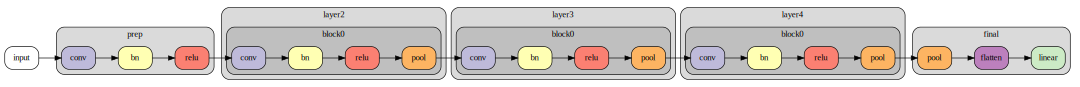

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       7.1061       1.8428       0.3630       0.5067       1.5510       0.4748       7.6128
           2       0.2000       6.3261       1.2593       0.5511       0.4259       0.9947       0.6382      14.3649
           3       0.3000       6.3209       0.9907       0.6550       0.4232       1.2079       0.6030      21.1089
           4       0.4000       6.3778       0.9085       0.6850       0.4174       0.9282       0.6871      27.9042
           5       0.3750       6.3116       0.8053       0.7224       0.4247       0.6537       0.7720      34.6405
           6       0.3500       6.3130       0.7211       0.7497       0.4153       1.2531       0.6394      41.3688
           7       0.3250       6.3189       0.6503       0.7743       0.4169       0.6495       0.7794      48.1046
           8       0.3000       6.3037       0.6169       0.7885

In [15]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(c=[64,128,256,512], block=shortcut_block, prep_bn_relu=True, concat_pool=False)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, bn scale init=1, classifier weight=0.125 (47s; test acc 91.1%)

By default in PyTorch (0.4), initial batch norm scales are chosen uniformly at random from the interval [0,1]. Channels which are initialised near zero could be wasted so we replace this with a constant initialisation at 1. 
This leads to a larger signal through the network and to compensate we introduce an overall constant multiplicative rescaling of the final classifier. A rough manual optimisation of this extra hyperparameter suggest that 0.125 is a reasonable value. 
(The low value makes predictions less certain and appears to ease optimisation.) 

With these changes in place, 20 epoch training reaches a test accuracy of 91.1% in 47s. 

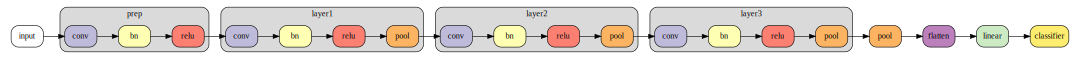

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       6.3403       1.7987       0.3593       0.4172       1.3223       0.5272       6.7575
           2       0.2000       6.3290       1.1270       0.6037       0.4232       1.0781       0.6094      13.5097
           3       0.3000       6.3369       0.8690       0.6999       0.4222       0.8363       0.7167      20.2688
           4       0.4000       6.3478       0.7425       0.7457       0.4345       0.6904       0.7611      27.0511
           5       0.3750       6.3349       0.6519       0.7798       0.4166       0.6214       0.7931      33.8026
           6       0.3500       6.3139       0.5802       0.8052       0.4156       0.5661       0.8073      40.5320
           7       0.3250       6.3010       0.5361       0.8219       0.4381       0.6358       0.7863      47.2711
           8       0.3000       6.2955       0.5063       0.8314

In [16]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net(extra_layers=(), res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - double width, 60 epoch train! (321s; test acc 93.5%)

ne approach that doesn't seem particularly promising is to just add width. 

If we double the channel dimensions and train for 60 epochs we can reach 93.5% test accuracy with a 5 layer network. This is nice but not efficient since training now takes 321s.

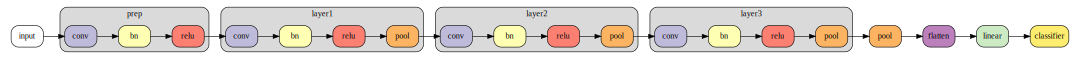

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333      22.3125       1.8858       0.3374       1.9564       1.4326       0.5003      24.2689
           2       0.0667      15.1426       1.2436       0.5631       1.0847       1.0720       0.6192      40.4962
           3       0.1000      15.1458       0.9370       0.6789       1.0847       0.8097       0.7105      56.7267
           4       0.1333      15.1657       0.7729       0.7375       1.0869       0.6946       0.7663      72.9793
           5       0.1667      15.1852       0.6779       0.7698       1.0900       0.6604       0.7802      89.2545
           6       0.2000      15.1860       0.6158       0.7918       1.0901       0.7596       0.7438     105.5306
           7       0.2333      15.1922       0.5657       0.8112       1.0917       0.6026       0.7933     121.8144
           8       0.2667      15.1778       0.5310       0.8225

In [17]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
c = 128

n = net(channels={'prep': c, 'layer1': 2*c, 'layer2': 4*c, 'layer3': 8*c}, extra_layers=(), res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - extra:L1+L2+L3 network, 60 epochs, cutout=12 (180s, 95.0% test acc) 

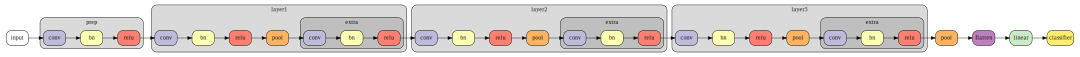

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       9.3183       1.8617       0.3371       0.7389       1.3728       0.5142      10.0572
           2       0.0667       8.4191       1.1772       0.5780       0.5814       1.1226       0.6157      19.0577
           3       0.1000       8.4233       0.8895       0.6883       0.5772       0.8193       0.7135      28.0582
           4       0.1333       8.4335       0.7649       0.7314       0.5761       0.7390       0.7409      37.0678
           5       0.1667       8.4097       0.6843       0.7616       0.5755       0.5852       0.7982      46.0530
           6       0.2000       8.3978       0.6258       0.7813       0.5766       0.6035       0.7891      55.0274
           7       0.2333       8.3984       0.5947       0.7956       0.5779       0.5446       0.8107      64.0037
           8       0.2667       8.4082       0.5576       0.8119

In [18]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
cutout=12

n = net(extra_layers=['layer1', 'layer2', 'layer3'], res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network Residual:L1+L3, 20 epochs (66s; test acc 93.7%)

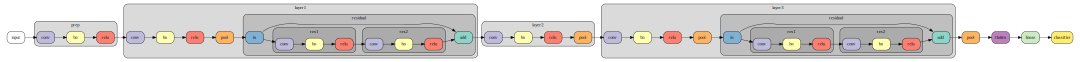

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       9.3508       1.5746       0.4306       0.6451       1.5657       0.4726       9.9959
           2       0.2000       9.3428       0.9168       0.6762       0.6515       0.8914       0.6955      19.9902
           3       0.3000       9.3528       0.7209       0.7460       0.6515       0.7172       0.7502      29.9944
           4       0.4000       9.3344       0.6118       0.7865       0.6477       0.6447       0.7743      39.9765
           5       0.3750       9.3525       0.5321       0.8158       0.6497       0.5048       0.8268      49.9787
           6       0.3500       9.3222       0.4652       0.8389       0.6521       0.4899       0.8365      59.9530
           7       0.3250       9.3280       0.4308       0.8523       0.6494       0.4825       0.8354      69.9305
           8       0.3000       9.3089       0.3922       0.8682

In [19]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network, 24 epochs (79s; test acc 94.1%)

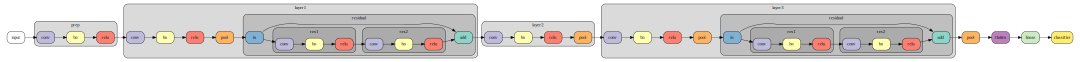

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800       9.3247       1.5972       0.4223       0.6501       1.2487       0.5701       9.9748
           2       0.1600       9.3216       0.9226       0.6696       0.6490       0.9174       0.6806      19.9453
           3       0.2400       9.3133       0.7158       0.7475       0.6514       0.7755       0.7483      29.9100
           4       0.3200       9.3142       0.6173       0.7845       0.6490       0.8044       0.7279      39.8732
           5       0.4000       9.3204       0.5529       0.8067       0.6514       0.6007       0.7862      49.8450
           6       0.3789       9.3148       0.4934       0.8294       0.6482       0.5678       0.8073      59.8080
           7       0.3579       9.3175       0.4426       0.8476       0.6496       0.5588       0.8043      69.7751
           8       0.3368       9.3127       0.4095       0.8602

In [20]:
lr_schedule = PiecewiseLinear([0, 5, 24], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)